# Mean-flow Depth - Model 02


## Import required libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import pickle
from utils import Scatter_Violin_Plots, Performance_metrics, Hbar
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GroupShuffleSplit, GroupKFold

## Import dataset

In [2]:
# Import the training dataset
train = pd.read_csv('./DataPreProcessing/df_Train.csv', converters={'site_no': str}, low_memory=False)

# Import the testing dataset
test = pd.read_csv('./DataPreProcessing/df_Test.csv', converters={'site_no': str}, low_memory=False)

## Split dataset into train and test sets

In [3]:
# Spliting the dependent (y) variable and independent (X) variables for training dataset
y_train = train[['mean_depth_va_mf']]
X_train = train[['QE_cms', 'TotDASqKM', 'CAT_EVI_OND_2011', 'CAT_EVI_AMJ_2012',
                  'CAT_EVI_JAS_2012', 'CAT_EVI_JFM_2012', 'ACC_NDAMS2010', 'CAT_POPDENS10', 'StreamOrde',
                  'D50_mm_', 'Mean_AI', 'NLCD_Developed_%', 'NLCD_Forest_%', 'NLCD_Agriculture_%', 
                  'MINELEVSMO', 'SLOPE', 'CAT_SILTAVE', 'CAT_CLAYAVE','CAT_SANDAVE']]

# Spliting the dependent (y) variable and independent (X) variables for testing dataset 
y_test = test[['mean_depth_va_mf']]
X_test = test[['QE_cms', 'TotDASqKM', 'CAT_EVI_OND_2011', 'CAT_EVI_AMJ_2012',
               'CAT_EVI_JAS_2012', 'CAT_EVI_JFM_2012', 'ACC_NDAMS2010', 'CAT_POPDENS10', 'StreamOrde',
               'D50_mm_', 'Mean_AI', 'NLCD_Developed_%', 'NLCD_Forest_%', 'NLCD_Agriculture_%', 
               'MINELEVSMO', 'SLOPE', 'CAT_SILTAVE', 'CAT_CLAYAVE','CAT_SANDAVE']]

## XGBoost Regression model

### a) Primary training

In [23]:
# Define the range of XGBR hyperparameters
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
              'max_depth': range(3, 8, 1),
              'min_child_weight': range(3, 8, 1),
              'subsample': [0.7, 0.8, 0.9, 1.0],
              'colsample_bytree': [0.7, 0.8, 0.9, 1.0],
              }
XGB= XGBRegressor(random_state=42)
XGB_grid= GridSearchCV(estimator=XGB, param_grid=param_grid, scoring='neg_mean_squared_error', cv=4)

In [24]:
# Train the model using defined XGBR hyperparameters 
XGB_grid.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=4

In [25]:
# Printing the best results out of training models
print(XGB_grid.best_params_)
print(XGB_grid.best_score_)

{'colsample_bytree': 1.0, 'learning_rate': 0.2, 'max_depth': 4, 'min_child_weight': 5, 'subsample': 0.8}
-0.9537460615669762


### b) Final training

In [108]:
# Define the final XGBR hyperparameter
xgb = XGBRegressor(colsample_bytree= 0.7, 
                   learning_rate= 0.08, 
                   max_depth= 12, 
                   min_child_weight= 3, 
                   subsample= 0.8, 
                   random_state=42)

In [109]:
# Train the model using the final XGBR hyperparameters
xgb.fit(X_train.to_numpy(), y_train.to_numpy().ravel())

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.08, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [110]:
# Export and save the final trained model 
with open('./XGBR/Best_Param/meanflow_depth_m2_xgbr', "wb") as fp:
    pickle.dump(xgb, fp)

In [111]:
# Import the final trained model 
with open('./XGBR/Best_Param/meanflow_depth_m2_xgbr', "rb") as fp:
    xgb= pickle.load(fp)

In [112]:
# Make prediction on training dataset using final trained model
xgb_pred_train = xgb.predict(X_train.values)

# Make prediction on tsting dataset using final trained model
xgb_pred_test = xgb.predict(X_test.values)

## Validation through Performance Metrics

In [113]:
Metrics = pd.DataFrame()
Model_names = [ 'Train', 'Test']
pred_list = [xgb_pred_train, xgb_pred_test]
obs_list = [ y_train, y_test]

for i in range(0,2):
    X = obs_list[i]
    Y = pred_list[i]
    df = pd.DataFrame({f'{Model_names[i]}': [ Performance_metrics(X, Y, "Yes")[0], Performance_metrics(X, Y, "Yes")[1], Performance_metrics(X, Y, "Yes")[2], Performance_metrics(X, Y, "Yes")[3], Performance_metrics(X, Y, "Yes")[4]]})
    Metrics= pd.concat([df, Metrics], axis=1)

Metrics = Metrics.rename( index={  0:'R\N{SUPERSCRIPT TWO}', 1:'NSE', 2:'KGE', 3:'APB (%)',  4:'RMSE (cms)'})
Metrics.style

,Test,Train
R²,0.68,0.99
NSE,0.67,0.99
KGE,0.79,0.97
APB (%),33.89,4.45
RMSE (cms),0.73,0.14


## Visualization of Scatter and Violin Plots for Training and Testing Datasets

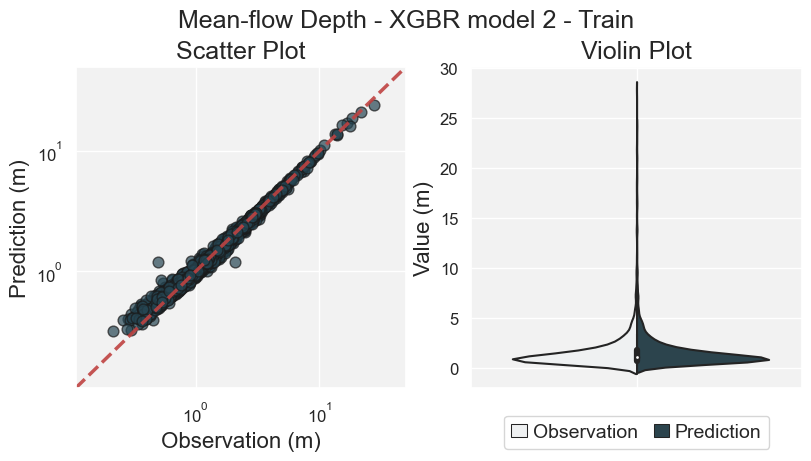

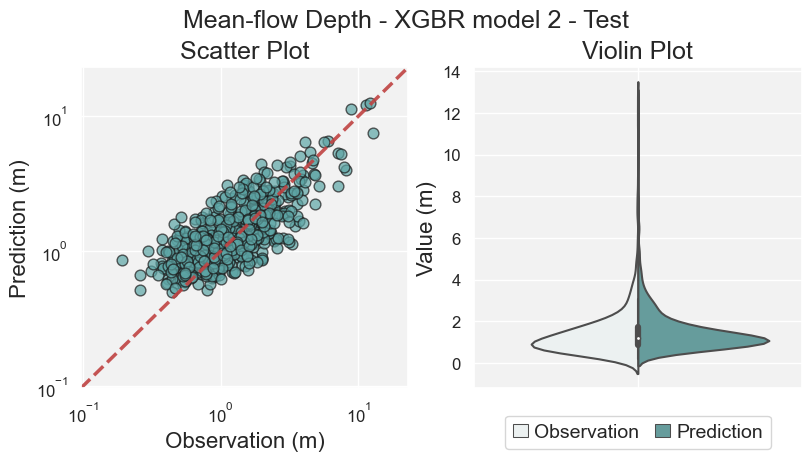

In [114]:
Title = ['Mean-flow Depth - XGBR model 2 - Train', 'Mean-flow Depth - XGBR model 2 - Test']
fc = ['#264653', '#5DA5A5']
pred_list = [xgb_pred_train, xgb_pred_test]
obs_list = [ y_train, y_test]

for i in range (0,2):
    X = obs_list[i]
    Y = pred_list[i]
    Scatter_Violin_Plots(X, Y, "Observation (m)", "Prediction (m)", "Value (m)", Title[i], fc[i])

## Mean Decrease in Impurity Analysis

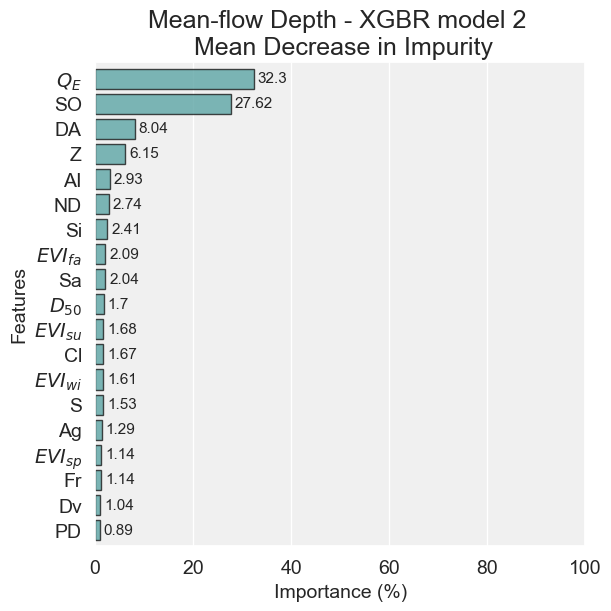

In [115]:
# Rename attributes
Columns=  ['$Q_{E}$','DA','$EVI_{fa}$', '$EVI_{sp}$', '$EVI_{su}$', '$EVI_{wi}$', 'ND', 'PD', 'SO', '$D_{50}$', 'AI','Dv', 'Fr','Ag', 'Z', 'S', 'Si', 'Cl', 'Sa']

# MDI analysis
result_train = permutation_importance(xgb, X_train.values, y_train, n_repeats=10, random_state=42, n_jobs=2)
importances_train = xgb.feature_importances_
xgb_importances_MDI_train = pd.Series(importances_train, index=Columns)
xgb_importances_MDI_train.sort_values(ascending=True, inplace=True)
xgb_importances_MDI_train = xgb_importances_MDI_train.multiply(100)
xgb_importances_MDI_train = xgb_importances_MDI_train.round( decimals=2)

# Visualization of results
Hbar(xgb_importances_MDI_train, 'Mean-flow Depth - XGBR model 2 \n Mean Decrease in Impurity', '#5DA5A5')